# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works better than Euler Deconvolution. It will show how the solution converges. This is also the first synthetic that will be shown in the paper.

In [6]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create a model and data

Make a model from a dipole. Add an interfering source at the edge of the region and some gaussian random noise.

Number of data: 11918


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


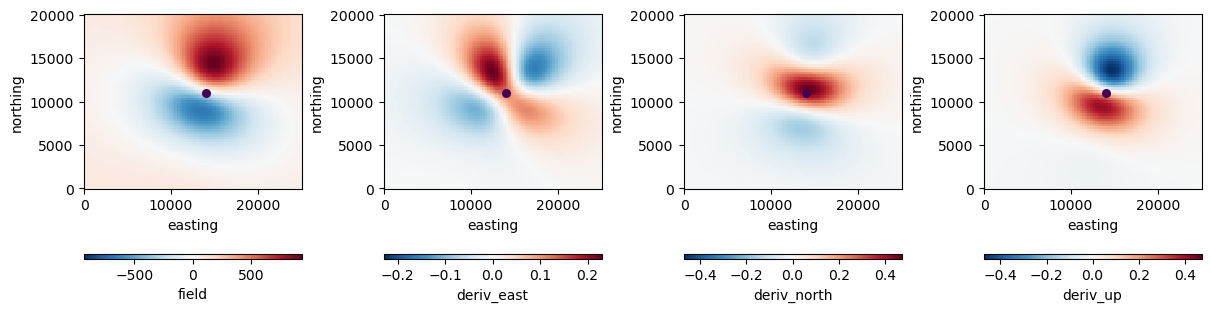

In [57]:
region = [-5e3, 30e3, -5e3, 25e3]
region_crop = [0, 25e3, 0, 20e3]
coordinates = vd.grid_coordinates(region, spacing=300, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (14e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Interfering source
other = hm.dipole_magnetic(
    coordinates,
    dipoles=(5e3, 0e3, -6e3),
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
# magnetic_anomaly += sum(b * f for b, f in zip(other, main_field))

# Add noise and the base level
# magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
pad_width = {
    "easting": data.easting.size // 2,
    "northing": data.northing.size // 2,
}
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
data["deriv_up"] = xrft.unpad(
    hm.derivative_upward(
        xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
    ), 
    pad_width,
)
data["deriv_east_east"] = hm.derivative_easting(data.deriv_east)
data["deriv_north_north"] = hm.derivative_northing(data.deriv_north)
data["deriv_up_up"] = xrft.unpad(
    hm.derivative_upward(
        xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None),
        order=2,
    ), 
    pad_width,
)
data["deriv_east_north"] = hm.derivative_northing(data.deriv_east)
data["deriv_up_east"] = hm.derivative_easting(data.deriv_up)
data["deriv_up_north"] = hm.derivative_northing(data.deriv_up)

# Add back the height
data = data.assign_coords(height=data.height)

data = data.sel(easting=slice(*region_crop[:2]), northing=slice(*region_crop[2:4]))

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

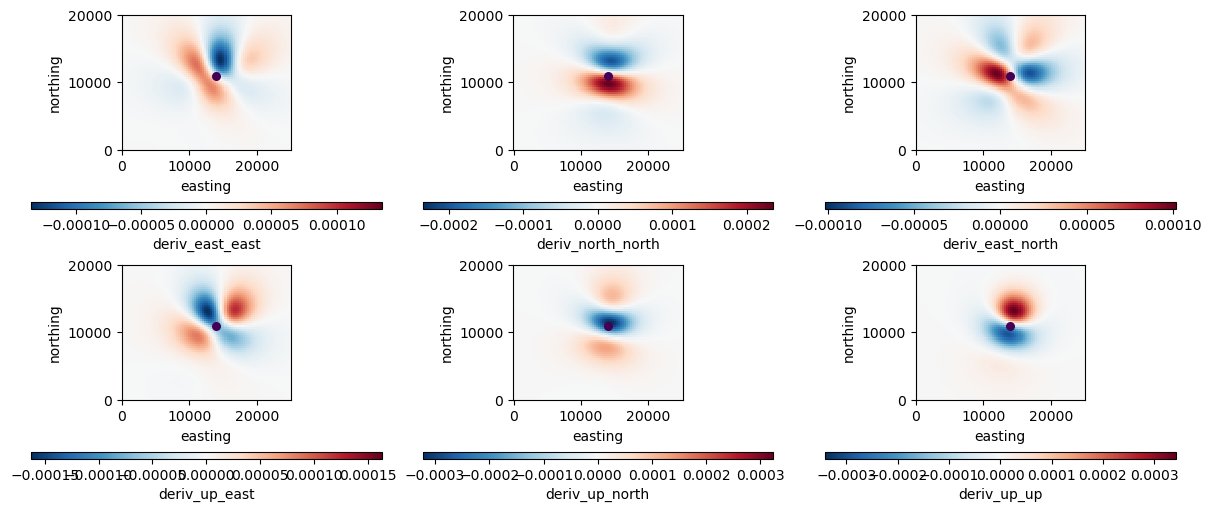

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), layout="constrained")
for field, ax in zip(["deriv_east_east", "deriv_north_north", "deriv_east_north", "deriv_up_east", "deriv_up_north", "deriv_up_up", ], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Deconvolution

Run Euler deconvolution on a single data window with the correct SI.

In [59]:
%%time
ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ed.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ed.location_}")
print(f"  STD       = {np.sqrt(np.diag(ed.covariance_))}")

Base level:
  True      = 100
  Estimated = 94.23929667253392
Position:
  True      = (14000.0, 11000.0, -5000.0)
  Estimated = [14001.21216443 11004.33790864 -5006.61674779]
  STD       = [0.52536701 0.32784374 0.26192885 0.0092919 ]
CPU times: user 2.68 ms, sys: 0 ns, total: 2.68 ms
Wall time: 2.26 ms


## Finite-difference Euler deconvolution

In [60]:
%%time
edfd = euler.EulerDeconvolutionFD().fit_grid(data)
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {edfd.location_}")
print(f"  STD       = {np.sqrt(np.diag(edfd.covariance_))}")
print(f"SI: {edfd.structural_index_}")

Position:
  True      = (14000.0, 11000.0, -5000.0)
  Estimated = [13997.8114118  11008.71684614 -5789.75488546]
  STD       = [5.69970778e-01 3.35674186e-01 5.46875083e-01 2.73572762e-04]
SI: 2.9957616027316987
CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 10.3 ms


## Euler Inversion

Now run the Euler inversion with the same SI.

In [61]:
%%time
ei = euler.EulerInversion(structural_index=3).fit_grid(
    data, weights=(1, 0.1, 0.1, 0.05)
)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.location_}")
print(f"  STD       = {np.sqrt(np.diag(ei.covariance_))}")

Base level:
  True      = 100
  Estimated = 94.4339916935334
Position:
  True      = (14000.0, 11000.0, -5000.0)
  Estimated = [14001.2460685  11004.12271085 -5006.19302903]
  STD       = [0.81005969 0.47484801 0.37321452 0.01733582]
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 38.6 ms


Euler inversion seems to be slightly worse at the base level but much better at the position estimate!

## Tilt Euler deconvolution

In [64]:
table = vd.grid_to_table(data)

A = np.sqrt(table.deriv_east ** 2 + table.deriv_north ** 2 + table.deriv_up ** 2)
H = np.sqrt(table.deriv_east ** 2 + table.deriv_north ** 2)
kx = 1 / A ** 2 * (
    H * table.deriv_up_east - table.deriv_up / H * (
        table.deriv_east * table.deriv_east_east 
        + table.deriv_north * table.deriv_east_north
    )
)
ky = 1 / A ** 2 * (
    H * table.deriv_up_north - table.deriv_up / H * (
        table.deriv_east * table.deriv_east_north 
        + table.deriv_north * table.deriv_north_north
    )
)
kz = 1 / A ** 2 * (
    H * table.deriv_up_up - table.deriv_up / H * (
        table.deriv_east * table.deriv_up_east 
        + table.deriv_north * table.deriv_up_north
    )
)
jacobian = np.empty((table.field.size, 3))
jacobian[:, 0] = kx.values.ravel()
jacobian[:, 1] = ky.values.ravel()
jacobian[:, 2] = kz.values.ravel()
pseudo_data = (kx * table.easting + ky * table.northing + kz * table.height).values.ravel()
hessian = jacobian.T @ jacobian
cofactor = np.linalg.inv(hessian)
parameters = cofactor @ jacobian.T @ pseudo_data
pseudo_residuals = pseudo_data - jacobian @ parameters
chi_squared = np.sum(pseudo_residuals**2) / (pseudo_data.size - parameters.size)
covariance = chi_squared * cofactor
parameters, true_coordinates

(array([12670.28742095, 11036.25739818, -5771.7072452 ]),
 (14000.0, 11000.0, -5000.0))

In [62]:
table = vd.grid_to_table(data)

A = np.sqrt(table.deriv_east ** 2 + table.deriv_north ** 2 + table.deriv_up ** 2)
Ap = np.sqrt(table.deriv_up ** 2 + A ** 2)
kx = 1 / Ap ** 2 * (
    A * table.deriv_up_east - table.deriv_up / A * (
        table.deriv_east * table.deriv_east_east 
        + table.deriv_north * table.deriv_east_north
        + table.deriv_up * table.deriv_up_east
    )
)
ky = 1 / Ap ** 2 * (
    A * table.deriv_up_north - table.deriv_up / A * (
        table.deriv_east * table.deriv_east_north 
        + table.deriv_north * table.deriv_north_north
        + table.deriv_up * table.deriv_up_north
    )
)
kz = 1 / Ap ** 2 * (
    A * table.deriv_up_up - table.deriv_up / A * (
        table.deriv_east * table.deriv_up_east
        + table.deriv_north * table.deriv_up_north
        + table.deriv_up * table.deriv_up_up
    )
)
jacobian = np.empty((table.field.size, 3))
jacobian[:, 0] = kx.values.ravel()
jacobian[:, 1] = ky.values.ravel()
jacobian[:, 2] = kz.values.ravel()
pseudo_data = (kx * table.easting + ky * table.northing + kz * table.height).values.ravel()
hessian = jacobian.T @ jacobian
cofactor = np.linalg.inv(hessian)
parameters = cofactor @ jacobian.T @ pseudo_data
pseudo_residuals = pseudo_data - jacobian @ parameters
chi_squared = np.sum(pseudo_residuals**2) / (pseudo_data.size - parameters.size)
covariance = chi_squared * cofactor
parameters, true_coordinates

(array([11854.99965897, 11282.59075035, -5705.65115418]),
 (14000.0, 11000.0, -5000.0))

## Make a figure for the paper

Show the observed and predicted data, estimates from both methods, and progress per iteration of the Euler inversion. 

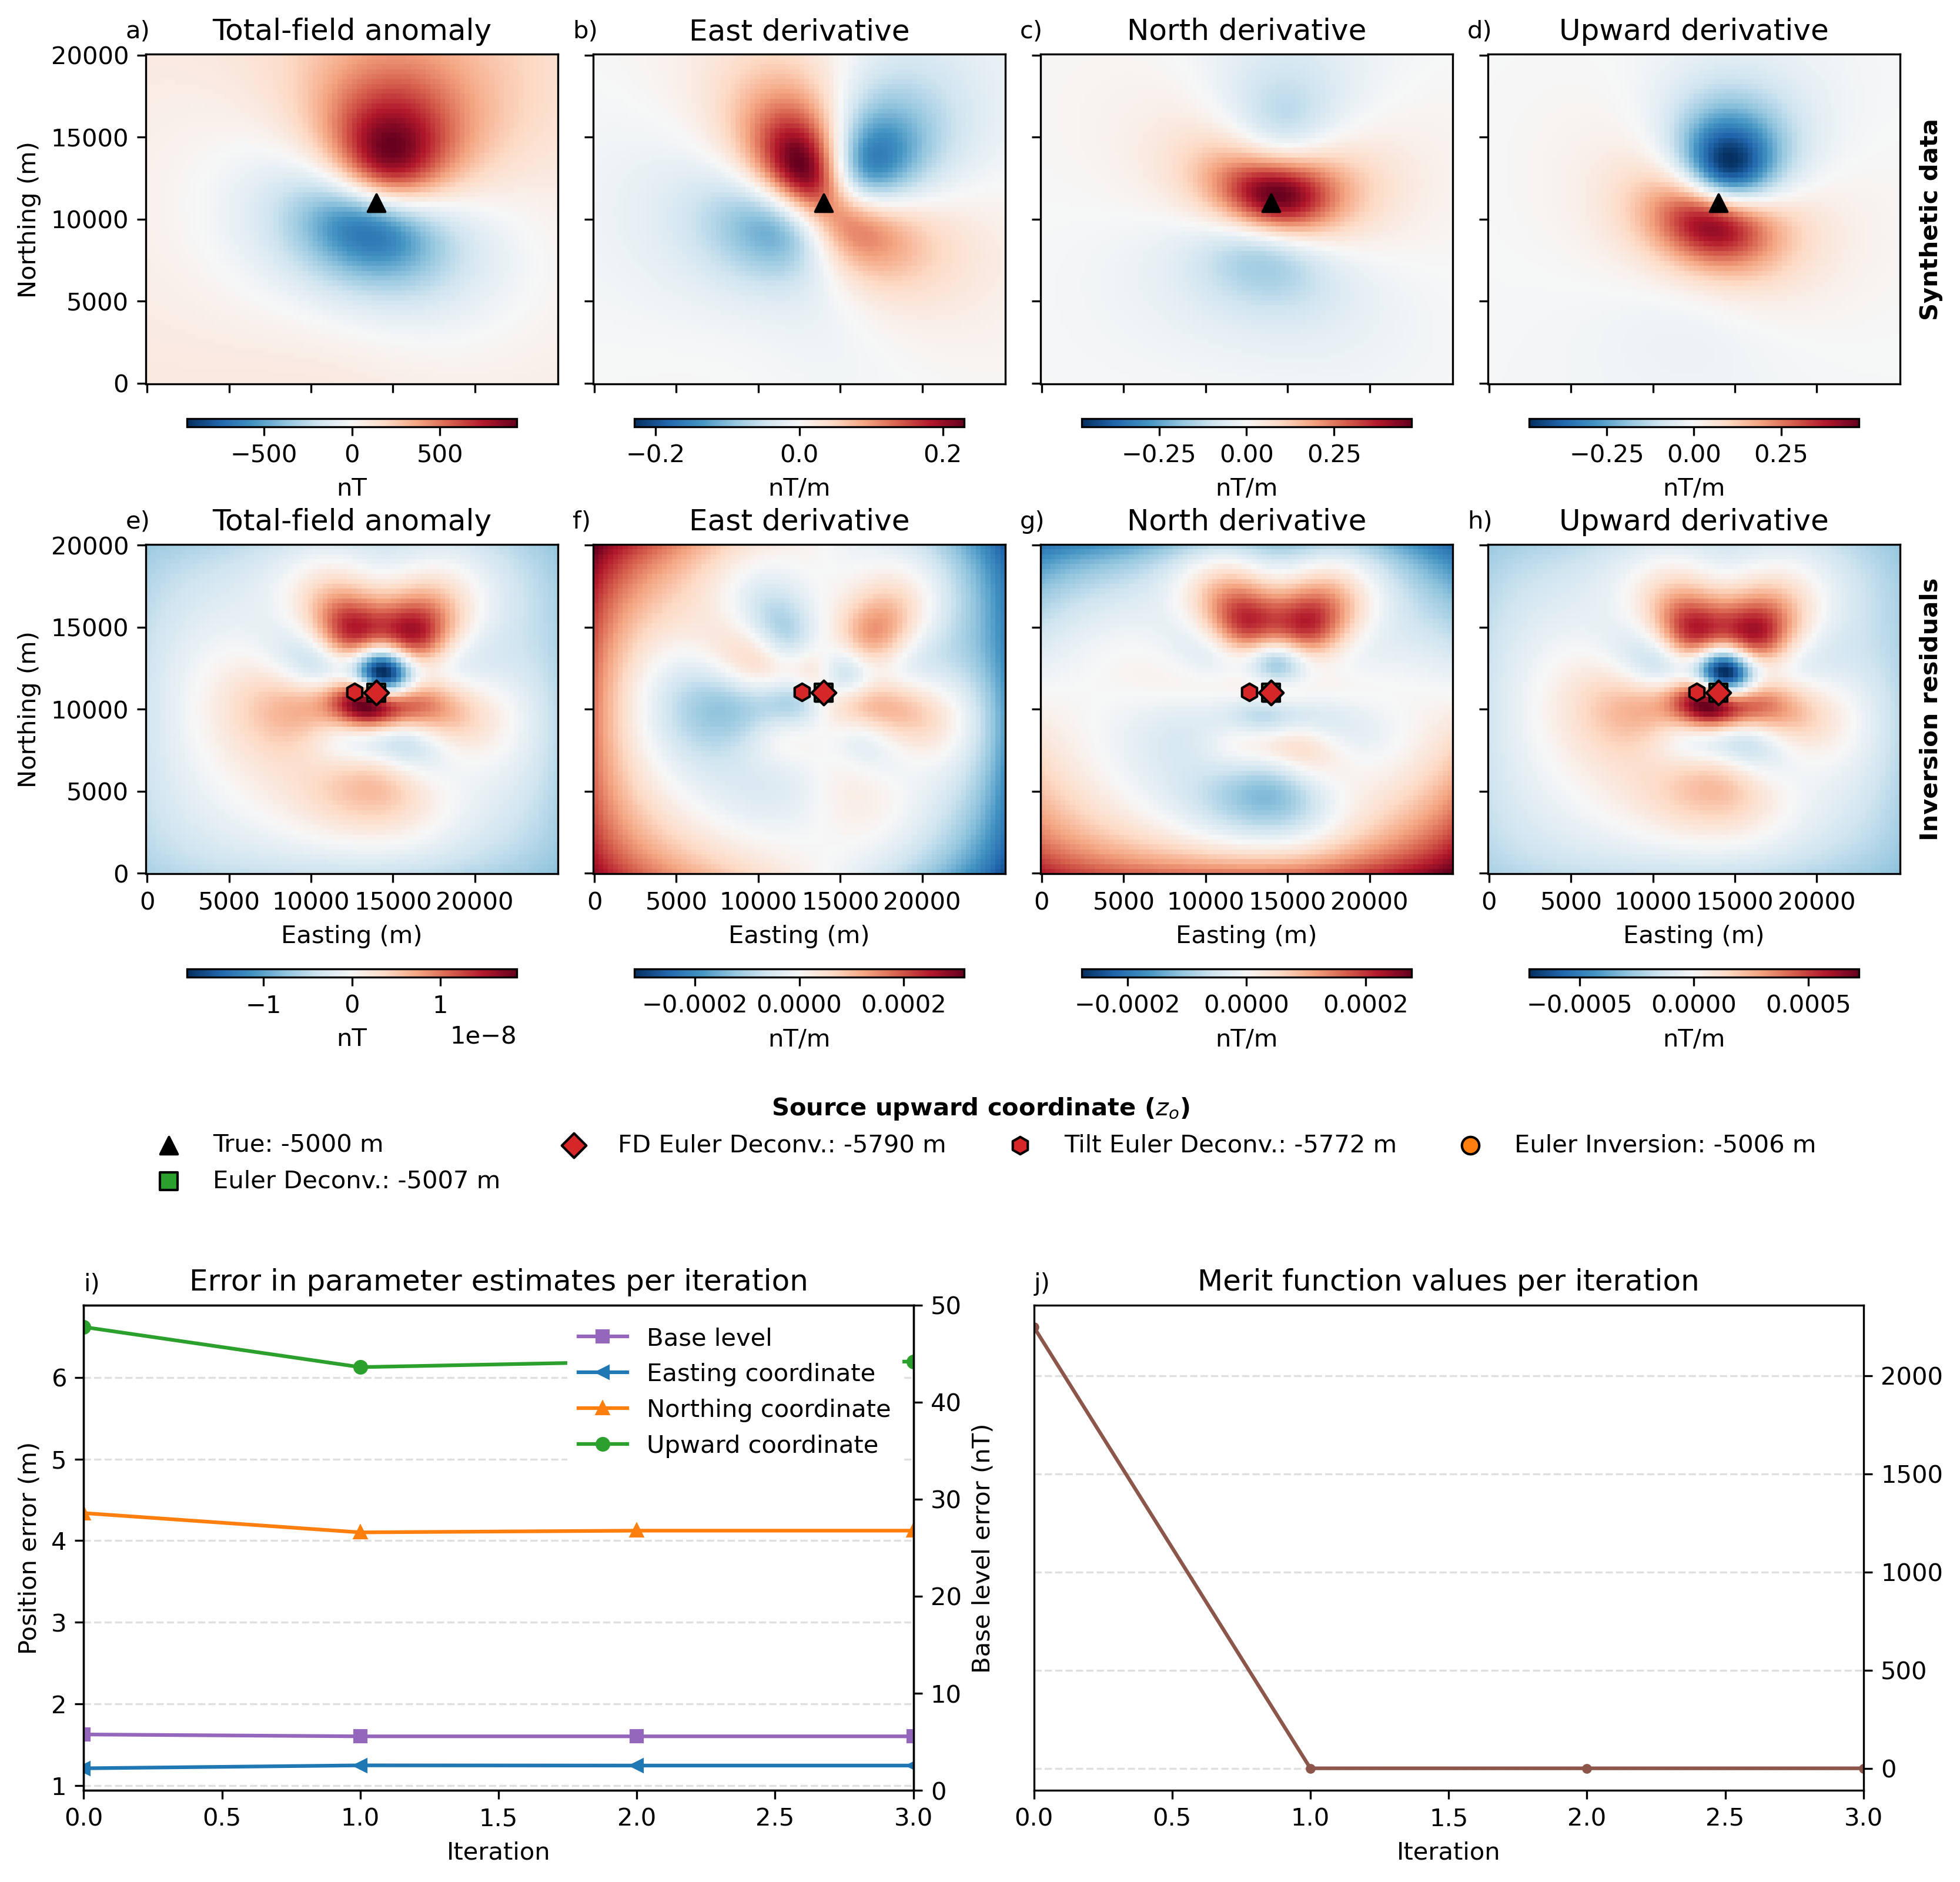

In [65]:
estimates = np.array(ei.location_per_iteration_)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(ei.base_level_per_iteration_)
base_error = np.abs(base_level - base_levels)

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig = plt.figure(figsize=(11, 10.5), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=[2, 1])

axes = figures[0].subplots(2, 4, sharey=True, sharex=True)

marker_size = 50
cbkwargs = dict(orientation="horizontal", aspect=40, shrink=0.8)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
data_names = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
for field, ax, label in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[0, :].ravel(), "abcd"
):
    ax.set_aspect("equal")
    tmp = data[field].plot.pcolormesh(ax=ax, add_labels=False, add_colorbar=False)
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    ax.set_title(data_names[field])
for field, ax in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[1, :].ravel()
):
    ax.set_aspect("equal")
    ax.set_title(data_names[field])
    tmp = (data[field] - ei.predicted_grid_[field]).plot.pcolormesh(
        ax=ax, add_labels=False, add_colorbar=False
    )
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    true = ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    inv = ax.scatter(
        *ei.location_[:2],
        c=colors[1],
        s=marker_size,
        marker="o",
        linewidths=1,
        edgecolors="black",
    )
    deconv = ax.scatter(
        *ed.location_[:2],
        c=colors[2],
        s=marker_size,
        marker="s",
        linewidths=1,
        edgecolors="black",
    )
    fd = ax.scatter(
        *edfd.location_[:2],
        c=colors[3],
        s=marker_size,
        marker="D",
        linewidths=1,
        edgecolors="black",
    )
    tilt = ax.scatter(
        *parameters[:2],
        c=colors[3],
        s=marker_size,
        marker="h",
        linewidths=1,
        edgecolors="black",
    )
figures[0].legend(
    [true, deconv, fd, tilt, inv],
    [
        f"True: {true_coordinates[-1]:.0f} m",
        f"Euler Deconv.: {ed.location_[-1]:.0f} m",
        f"FD Euler Deconv.: {edfd.location_[2]:.0f} m",
        f"Tilt Euler Deconv.: {parameters[2]:.0f} m",
        f"Euler Inversion: {ei.location_[-1]:.0f} m",
    ],
    title="Source upward coordinate ($z_o$)",
    title_fontproperties=dict(weight="bold"),
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=4,
    loc="outside lower center",
    borderpad=1.5,
)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 25e3, 5e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Synthetic data", fontweight="bold", labelpad=8)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Inversion residuals", fontweight="bold", labelpad=8)
for ax, label in zip(axes.ravel(), "abcdefgh"):
    ax.text(-0.05, 1.05, f"{label})", transform=ax.transAxes)

ax1, ax2 = figures[1].subplots(1, 2)

ax1.grid(axis="y", alpha=0.4, linestyle="--")
(east,) = ax1.plot(east_error, color=colors[0], marker="<", linestyle="-", markersize=5)
(north,) = ax1.plot(
    north_error, color=colors[1], marker="^", linestyle="-", markersize=5
)
(up,) = ax1.plot(up_error, color=colors[2], marker="o", linestyle="-", markersize=5)
twin = ax1.twinx()
(base,) = twin.plot(
    base_error, color=colors[4], marker="s", linestyle="-", markersize=5
)
ax1.legend(
    [base, east, north, up],
    ["Base level", "Easting coordinate", "Northing coordinate", "Upward coordinate"],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
twin.set_ylim(0, base_level / 2)
twin.set_ylabel("Base level error (nT)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in parameter estimates per iteration")
ax1.set_xlim(0, len(east_error) - 1)

ax2.grid(axis="y", alpha=0.4, linestyle="--")
ax2.plot(ei.merit_, label="Merit", color=colors[5], marker=".", linestyle="-")

ax2.set_xlabel("Iteration")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Merit function values per iteration")
ax2.set_xlim(0, len(east_error) - 1)

for ax, label in zip([ax1, ax2], "ij"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-proof-of-concept.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)